In [371]:
#SQLite Db
import sqlite3
#dataframes
import pandas as pd

import numpy as np
#plots
import matplotlib.pyplot as plt
#lsq interpolation
import scipy.interpolate as si 

In [372]:
# Create the connection.
cnx = sqlite3.connect('data/data.db')

#Find the name of the table
res = cnx.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

turbine


In [373]:
#read sql
df = pd.read_sql_query("SELECT * FROM turbine", cnx)

In [374]:
#Split started column to two columns
df[['Date','Time']] = df.valuetime.str.split(" ",expand=True,)
df = df[['started','Date', 'Time', 'locname', 'plantno', 'power','wind']]

In [375]:
#change time format
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%H:%M:%S')
df

,started,Date,Time,locname,plantno,power,wind
0,2021-06-04 10:35:53.793993,2021-06-04,10:35:51,Ballincurry,1,698.0,8.700000
1,2021-06-04 10:35:53.793993,2021-06-04,10:35:52,Ballincurry,2,612.0,6.800000
2,2021-06-04 10:35:53.793993,2021-06-04,10:35:54,Ballincurry,1,704.0,8.300000
3,2021-06-04 10:35:53.793993,2021-06-04,10:35:55,Ballincurry,2,583.0,6.400000
4,2021-06-04 10:35:53.793993,2021-06-04,10:35:57,Ballincurry,1,716.0,8.500000
...,...,...,...,...,...,...,...
126220,2021-06-21 16:34:38.742056,2021-06-21,17:23:16,Ballincurry,1,1100.0,7.700000
126221,2021-06-21 16:34:38.742056,2021-06-21,17:23:17,Ballincurry,2,936.0,7.800000
126222,2021-06-21 16:34:38.742056,2021-06-21,17:23:19,Ballincurry,1,1065.0,8.300000
126223,2021-06-21 16:34:38.742056,2021-06-21,17:23:21,Ballincurry,2,958.0,8.400001


In [376]:
#create a df with hours 
#df1=pd.date_range("00:00:00", "23:00:00", freq="60min").strftime('%H:%M:%S')

#another times
#df2=pd.date_range("00:00:02", "23:00:02", freq="60min").strftime('%H:%M:%S')
#df3=pd.date_range("00:00:59", "23:00:59", freq="60min").strftime('%H:%M:%S')
#df_time=df1.append(df2)
#df_time=df_time.append(df3)

print(df1)

Index(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00',
       '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00',
       '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00'],
      dtype='object')


In [471]:
#keep only row with time format tt:00:00
#df_hourly=pd.DataFrame()
#for a in df1:
    #df_hourly = df_hourly.append(df.loc[df['Time'] == a])
#df_hourly.head(n=5)
df_hourly=df

In [472]:
#separe date time columns
df_hourly["DateTime"] = df_hourly["Date"] + " " + df_hourly["Time"]

#order ascending by wind to apply interpolation
df_hourly=df_hourly.sort_values(by=['power'], axis=0, ascending=True)

#positive values for power
df_hourly=df_hourly[(df_hourly.power >= 0.0)]

df_hourly.head(n=5)


,started,Date,Time,locname,plantno,power,wind,DateTime
85997,2021-06-09 12:53:55.145600,2021-06-11,10:46:01,Ballincurry,1,0.0,6.9,2021-06-11 10:46:01
94609,2021-06-09 12:53:55.145600,2021-06-11,14:53:38,Ballincurry,1,0.0,7.8,2021-06-11 14:53:38
86073,2021-06-09 12:53:55.145600,2021-06-11,10:48:07,Ballincurry,1,0.0,6.9,2021-06-11 10:48:07
94695,2021-06-09 12:53:55.145600,2021-06-11,14:55:57,Ballincurry,1,0.0,6.4,2021-06-11 14:55:57
94781,2021-06-09 12:53:55.145600,2021-06-11,14:58:15,Ballincurry,1,0.0,4.5,2021-06-11 14:58:15


In [473]:
#separe by plant no
df_hourly_1=df_hourly[(df_hourly.plantno == 1)]
df_hourly_2=df_hourly[(df_hourly.plantno == 2)]

#sort ascending
#df_hourly_2=df_hourly_2.sort_values(by=['power'])

#df_hourly_2=df_hourly_2[2:]

#choose one of the turbine
df_hourly=df_hourly_1

#sort again
df_hourly=df_hourly.sort_values(by=['wind'])

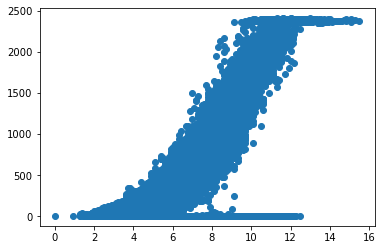

In [474]:
plt.plot(df_hourly["wind"], df_hourly["power"],"o")
plt.show()

## LSQ Spline

source: http://vadym-pasko.com/blog/2015/03/06/spline-approx-scipy.html

In [475]:
x=df_hourly["wind"].reset_index(drop=True)

y=df_hourly["power"].reset_index(drop=True)
wmin, wmax = min(x), max(x) 
pmin, pmax = min(y), max(y)

In [509]:
#Define some control points and set some variables:
n = len(x)
plotpoints = 100

#set spline degree and find knot vector:
k = 2

#Construct uniform knot vector:
knotspace = range(n)
knots = si.InterpolatedUnivariateSpline(knotspace, knotspace, k=k).get_knots()
knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))

#nknot - is the number of knots in the reduced knot vector (one without k repeating values at the endings).
nknot=5
knot_offset = (wmax - wmin)/(nknot + 1)
knots = np.linspace(knot_offset, wmax-knot_offset, nknot)

#define the vector of weights w in order to force our further approximations to pass close to the end points of the original data
wend = 3
num_points=len(x)
w = [wend] + [1]*(num_points-2) + [wend]

In [510]:
#Instantiate LSQUnivariateSpline class using coordinates of the data points, the knot vector and the weight vector:
lsqspline = si.LSQUnivariateSpline(x, y, knots, k=k, w=w)

In [511]:
# evaluate control points 
def getControlPoints(knots, k):
    n = len(knots) - 1 - k
    cx = np.zeros(n)
    for i in range(n):
        tsum = 0
        for j in range(1, k+1):
            tsum += knots[i+j]
        cx[i] = float(tsum)/k
    return cx

cp = getControlPoints(knots_full, k)

In [512]:
#Get full-length knot vector, spline coefficients and coordinates of control points along the x-axis:
knots = lsqspline.get_knots()
knots_full = np.concatenate(([knots[0]]*k, knots, [knots[-1]]*k))
coeffs_p = lsqspline.get_coeffs()
coeffs_w = getControlPoints(knots_full, k)

In [513]:
nsample = 100
xP = np.linspace(x[0], x[len(x) - 1], nsample)
yP = lsqspline(xP)

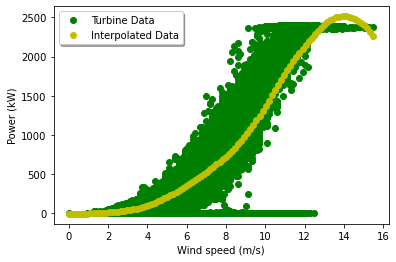

In [514]:
#plot results
fig, ax = plt.subplots()
ax.plot(x, y, 'go', label='Turbine Data')
ax.plot(xP, yP, 'yo', label='Interpolated Data')

plt.xlabel("Wind speed (m/s)")
plt.ylabel("Power (kW)")

legend = ax.legend(loc='upper left', shadow=True, fontsize='medium')
plt.show()

In [517]:
#save itnerpolated data to a df
di = pd.DataFrame({'Windspeed': xP,'Power': yP})

#positive values for power
di=di[(di.Power >= 0.0)]

di

,Windspeed,Power
9,1.409091,1.088154
10,1.565657,3.288506
11,1.722222,5.724707
12,1.878788,8.396757
13,2.035354,11.304656
...,...,...
95,14.873737,2430.905940
96,15.030303,2397.801062
97,15.186869,2359.246067
98,15.343434,2315.240957


### Met Eirean Data

In [518]:
#meteirean data
cnx = sqlite3.connect('MetEirean.db')

#Find the name of the table
res = cnx.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print(name[0])

met_eireann_api
met_eireann_com


In [529]:
me_full = pd.read_sql_query("SELECT * FROM met_eireann_com", cnx)
me=me_full[["period", "u100wind","v100wind"]]
me.head(5)


,period,u100wind,v100wind
0,2021-02-05 01:00:00,4.246,1.616
1,2021-02-05 02:00:00,4.422,1.046
2,2021-02-05 03:00:00,4.563,1.020
3,2021-02-05 04:00:00,4.392,0.513
4,2021-02-05 05:00:00,4.532,0.268


In [530]:
me['windspeed'] = np.sqrt(me['u100wind'].pow(2) + me['v100wind'].pow(2))
#values greater than 1 for windspeed
me=me[ (me.windspeed > 1.5) & (me.windspeed <15.5)]
me=me.sort_values(by=['windspeed'])
me.head(5)

<ipython-input-530-9a59442e738d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  me['windspeed'] = np.sqrt(me['u100wind'].pow(2) + me['v100wind'].pow(2))


,period,u100wind,v100wind,windspeed
61769,2021-05-28 12:00:00,0.536,-1.403,1.50190
62201,2021-05-28 12:00:00,0.536,-1.403,1.50190
61337,2021-05-28 12:00:00,0.536,-1.403,1.50190
62369,2021-05-29 12:00:00,1.472,-0.300,1.50226
62801,2021-05-29 12:00:00,1.472,-0.300,1.50226


## Interpolation

In [531]:
w, p = di['Windspeed'].values, di['Power'].values

# Interpolate (w,p)
f = si.interp1d(w, p, kind='cubic')

# Apply interpolation curve to windspeed values in forecast to get power.
me['power'] = me['windspeed'].apply(f).round(3)
me

,period,u100wind,v100wind,windspeed,power
61769,2021-05-28 12:00:00,0.536,-1.403,1.501900,2.364
62201,2021-05-28 12:00:00,0.536,-1.403,1.501900,2.364
61337,2021-05-28 12:00:00,0.536,-1.403,1.501900,2.364
62369,2021-05-29 12:00:00,1.472,-0.300,1.502260,2.369
62801,2021-05-29 12:00:00,1.472,-0.300,1.502260,2.369
...,...,...,...,...,...
1839,2021-02-13 16:00:00,-4.023,14.963,15.494383,2267.654
2531,2021-02-18 12:00:00,13.854,6.946,15.497749,2266.535
13259,2021-03-10 00:00:00,11.359,10.544,15.498478,2266.293
13475,2021-03-10 00:00:00,11.359,10.544,15.498478,2266.293


## Check Data

In [532]:
df1 = me.loc[(me['windspeed'] > 2.8) & (me['windspeed'] < 3) , ['windspeed','power']]
df1=df1.rename(columns={'power':'Power_ME'})
df2 = df_hourly.loc[(df_hourly["wind"] > 2.8) & (df_hourly["wind"] < 3) , ['wind','power']]
df2=df2.rename(columns={'power':'Power_Turbine'})
result = df1.append(df2, ignore_index=True, sort=False)
#result = pd.concat([df1, df2], axis=1)
result


,windspeed,Power_ME,wind,Power_Turbine
0,2.801951,29.741,NaN,NaN
1,2.801951,29.741,NaN,NaN
2,2.801951,29.741,NaN,NaN
3,2.802697,29.766,NaN,NaN
4,2.802697,29.766,NaN,NaN
...,...,...,...,...
1319,NaN,NaN,2.9,40.0
1320,NaN,NaN,2.9,61.0
1321,NaN,NaN,2.9,49.0
1322,NaN,NaN,2.9,56.0
